# Neural Operators

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split

In [3]:
path = r'../../1D 1 Column/Results'

In [4]:
# Check gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [5]:
# Load data
freq_data = np.genfromtxt("TTF_freq.csv", delimiter=",")

# Load pickle
with open("TTF_data_1000.pt", "rb") as f:
    TTF_data = pickle.load(f)

with open("Vs_values_1000.pt", "rb") as f:
    Vs_data = pickle.load(f)

with open("data_acc.pkl", "rb") as f:
    data_acc = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)
data_acc = np.array(data_acc)

In [6]:
class SignalDataset(torch.utils.data.Dataset):
    def __init__(self, data_acc, TTF_data):
        self.data_acc = data_acc
        self.TTF_data = TTF_data

    def __len__(self):
        return len(self.data_acc)

    def __getitem__(self, idx):
        # Input
        x = torch.tensor(self.data_acc[idx], dtype=torch.float32)
        x = x.permute(1, 0)
        # Output
        y = torch.tensor(self.TTF_data[idx], dtype=torch.float32)
        return x, y
    

dataset = SignalDataset(data_acc, TTF_data)

# Split data
test_size = 0.8*len(dataset)
batch_size = 200
train_data, test_data = torch.utils.data.random_split(dataset, [int(test_size), int(len(dataset) - test_size)])
train_loader = torch.utils.data.DataLoader(train_data, batch_size=200, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=200, shuffle=False)

In [7]:
import torch
import torch.nn as nn

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        self.scale = (1 / (in_channels * out_channels))
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, modes, dtype=torch.cfloat)
        )

    def compl_mul1d(self, input_data, weights):
        # (batch, in_channel, x) * (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input_data, weights)

    def forward(self, x):
        # x shape: (batch, in_channels, features)
        batchsize = x.shape[0]
        x_ft = torch.fft.rfft(x, dim=-1)
        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            x.size(-1) // 2 + 1,
            device=x.device,
            dtype=torch.cfloat
        )
        usable_modes = min(self.modes, x.size(-1) // 2 + 1)
        out_ft[:, :, :usable_modes] = self.compl_mul1d(
            x_ft[:, :, :usable_modes],
            self.weights[..., :usable_modes]
        )
        x = torch.fft.irfft(out_ft, n=x.size(-1), dim=-1)
        return x

# ----------------------------
# FNO model
# ----------------------------
class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()
        self.modes = modes
        self.width = width

        # Input: 2 channels (accelerations) per spatial location
        # We first permute input x from (batch, 2, 1500) to (batch, 1500, 2)
        # and then lift the 2 features to 'width'
        self.fc0 = nn.Linear(2, self.width)

        # Four spectral convolution layers (each from width -> width)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)

        # Flatten the (width, 1500) representation and map to the output
        self.fc1 = nn.Linear(self.width * 1500, 400)
        self.fc2 = nn.Linear(400, 1000)  # Output TTF signal of length 1000

    def forward(self, x):
        # x is expected to have shape (batch, 2, 1500)
        x = x.permute(0, 2, 1)         # shape becomes (batch, 1500, 2)
        x = self.fc0(x)                # shape becomes (batch, 1500, width)
        x = x.permute(0, 2, 1)         # shape becomes (batch, width, 1500)

        x = self.conv1(x)
        x = torch.relu(x)
        x = self.conv2(x)
        x = torch.relu(x)            # still (batch, width, 1500)

        x = x.reshape(x.size(0), -1)   # reshape to (batch, width * 1500)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)              # final output shape: (batch, 1000)
        return x



In [8]:
# Clean GPU
torch.cuda.empty_cache()

In [9]:
modes = 15
width = 32
model_acc2tf = FNO1d(modes, width)

# Test with a batch of 10 samples, each is (1, 30)
test_inp = torch.ones(10, 2, 1500)
test_out = model_acc2tf(test_inp)
print("Input shape :", test_inp.shape)   # (10, 1, 30)
print("Output shape:", test_out.shape)   # (10, 256)

Input shape : torch.Size([10, 2, 1500])
Output shape: torch.Size([10, 1000])


In [10]:
import torch.nn.init as init

# Initialize network weights by sampling from a normal distribution
def init_weights(m):
    if isinstance(m, nn.Linear):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, nn.Conv1d):
        init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            init.constant_(m.bias, 0)
    elif isinstance(m, SpectralConv1d):
        init.kaiming_normal_(m.weights, mode='fan_out', nonlinearity='relu')

model_acc2tf.apply(init_weights)

FNO1d(
  (fc0): Linear(in_features=2, out_features=32, bias=True)
  (conv1): SpectralConv1d()
  (conv2): SpectralConv1d()
  (fc1): Linear(in_features=48000, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=1000, bias=True)
)

In [11]:
# Loss function
criterion = nn.L1Loss()

# Optimizer
optimizer = torch.optim.Adam(model_acc2tf.parameters(), lr=5e-4, betas=(0.6, 0.99))

# Training loop
model_acc2tf.to(device)
model_acc2tf.train()
epochs = 2000
losses = []
for epoch in range(epochs):
    for i, (input_data, output_data) in enumerate(train_loader):
        input_data, output_data = input_data.to(device), output_data.to(device)

        optimizer.zero_grad()
        output = model_acc2tf(input_data)
        loss = criterion(output, output_data)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

        

Epoch 0, Loss: 2.6983933448791504
Epoch 100, Loss: 0.8851624131202698
Epoch 200, Loss: 0.7533411383628845
Epoch 300, Loss: 0.669721245765686
Epoch 400, Loss: 0.6239612698554993
Epoch 500, Loss: 0.578206479549408
Epoch 600, Loss: 0.5645084381103516
Epoch 700, Loss: 0.5144772529602051
Epoch 800, Loss: 0.4970283508300781
Epoch 900, Loss: 0.4765437841415405
Epoch 1000, Loss: 0.4554539620876312
Epoch 1100, Loss: 0.42795953154563904
Epoch 1200, Loss: 0.4175758957862854
Epoch 1300, Loss: 0.4035987854003906
Epoch 1400, Loss: 0.3837374150753021
Epoch 1500, Loss: 0.3731103837490082
Epoch 1600, Loss: 0.37869516015052795
Epoch 1700, Loss: 0.3541242480278015
Epoch 1800, Loss: 0.3525916337966919
Epoch 1900, Loss: 0.3486892879009247


Text(0.5, 0, 'Iteration')

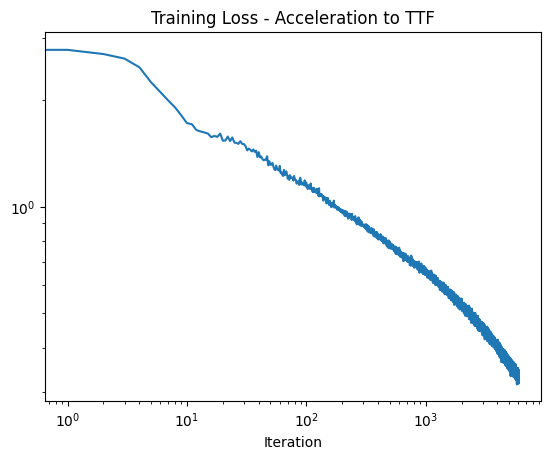

In [12]:
plt.loglog(losses)
plt.title("Training Loss - Acceleration to TTF")
plt.xlabel("Iteration")


In [19]:
# Check the model on test data
model_acc2tf.eval()
outputs = []
with torch.no_grad():
    for i, (input_data, output_data) in enumerate(test_loader):
        input_data, output_data = input_data.to(device), output_data.to(device)

        output = model_acc2tf(input_data)

        outputs.append(output.cpu().numpy())
        loss = criterion(output, output_data)
        print(f'Loss: {loss.item()}')

Loss: 0.3899911046028137


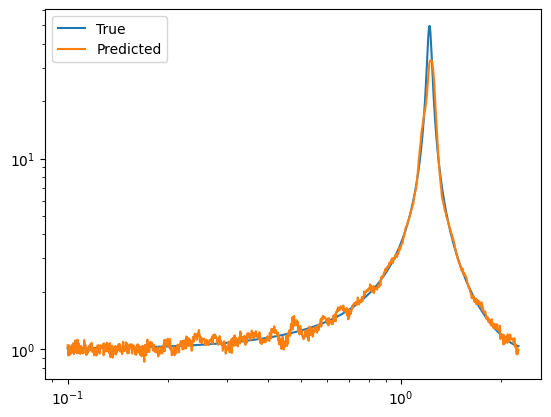

In [20]:
ix = np.random.randint(0, output_data.shape[0])
plt.figure()

plt.loglog(freq_data, output_data.cpu().numpy()[ix], label='True')
plt.loglog(freq_data, output.cpu().numpy()[ix], label='Predicted')
plt.legend()

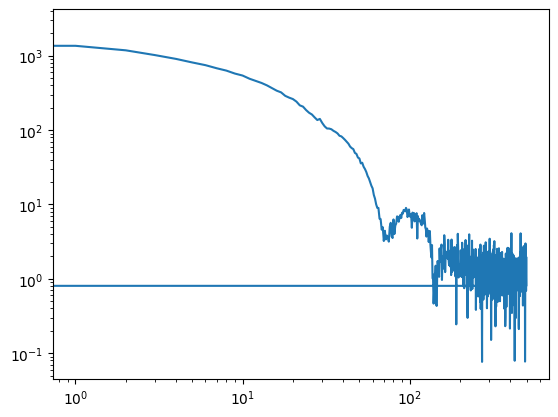

In [21]:
# FFT of the output
output_try = output.cpu().numpy()
output_fft = np.fft.fft(output_try[ix])

freq_fft = np.fft.fftfreq(len(output[ix]), d=1/1000)

plt.figure()
plt.loglog(freq_fft, np.abs(output_fft))


In [25]:
class Vs2AccDataset(torch.utils.data.Dataset):
    def __init__(self, data_acc, Vs_data):
        assert len(Vs_data) == len(data_acc), "vs_data and data_acc must have the same length"
        self.data_acc = data_acc
        self.Vs_data = Vs_data

    def __len__(self):
        return len(self.data_acc)

    def __getitem__(self, idx):
        # Input
        x = torch.tensor(self.Vs_data[idx], dtype=torch.float32) * torch.ones(30)

        # Output
        y = torch.tensor(self.data_acc[idx], dtype=torch.float32)
        y = y.permute(1, 0)

        return x, y

vs_dataset = Vs2AccDataset(data_acc, Vs_data)

In [26]:
Vs_train_data, Vs_test_data = torch.utils.data.random_split(vs_dataset, [int(test_size), int(len(vs_dataset) - test_size)])
Vs_train_loader = torch.utils.data.DataLoader(Vs_train_data, batch_size=batch_size, shuffle=True)
Vs_test_loader = torch.utils.data.DataLoader(Vs_test_data, batch_size=batch_size, shuffle=False)

In [27]:
import torch
import torch.nn as nn

class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes):
        super(SpectralConv1d, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes = modes

        self.scale = 1 / (in_channels * out_channels)
        self.weights = nn.Parameter(
            self.scale * torch.rand(in_channels, out_channels, modes, dtype=torch.cfloat)
        )

    def compl_mul1d(self, input_data, weights):
        # (batch, in_channel, x) * (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input_data, weights)

    def forward(self, x):
        # x shape: (batch, in_channels, features)
        batchsize = x.shape[0]
        # Fourier transform along the last dimension
        x_ft = torch.fft.rfft(x, dim=-1)
        out_ft = torch.zeros(
            batchsize,
            self.out_channels,
            x.size(-1) // 2 + 1,
            device=x.device,
            dtype=torch.cfloat
        )
        usable_modes = min(self.modes, x.size(-1) // 2 + 1)
        out_ft[:, :, :usable_modes] = self.compl_mul1d(
            x_ft[:, :, :usable_modes],
            self.weights[..., :usable_modes]
        )
        # Inverse Fourier transform to return to spatial domain
        x = torch.fft.irfft(out_ft, n=x.size(-1), dim=-1)
        return x

class FNO1d_VsToAcc_Channel1(nn.Module):
    def __init__(self, modes, width, num_grid_points=1500):
        """
        Branch 1: Predicts the first acceleration channel.
        Input:
            vs: Tensor of shape (batch, 30)
        Output:
            Tensor of shape (batch, 1, num_grid_points)
        """
        super(FNO1d_VsToAcc_Channel1, self).__init__()
        self.modes = modes
        self.width = width
        self.num_points = num_grid_points

        self.fc0 = nn.Linear(30 + 1, self.width)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)
        self.fc1 = nn.Linear(self.width * self.num_points, 400)
        self.fc2 = nn.Linear(400, self.num_points)  # Single channel

    def forward(self, vs):
        batchsize = vs.shape[0]
        # Create grid: (batch, num_points, 1)
        grid = torch.linspace(0, 1, self.num_points, device=vs.device).unsqueeze(0).repeat(batchsize, 1).unsqueeze(-1)
        # Expand vs: (batch, 30) -> (batch, num_points, 30)
        vs_expanded = vs.unsqueeze(1).repeat(1, self.num_points, 1)
        # Concatenate grid and vs: (batch, num_points, 31)
        x = torch.cat([grid, vs_expanded], dim=-1)

        x = self.fc0(x)            # (batch, num_points, width)
        x = x.permute(0, 2, 1)       # (batch, width, num_points)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.reshape(batchsize, -1)  # (batch, width * num_points)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)             # (batch, num_points)
        x = x.reshape(batchsize, 1, self.num_points)
        return x

class FNO1d_VsToAcc_Channel2(nn.Module):
    def __init__(self, modes, width, num_grid_points=1500):
        """
        Branch 2: Predicts the second acceleration channel.
        Input:
            vs: Tensor of shape (batch, 30)
        Output:
            Tensor of shape (batch, 1, num_grid_points)
        """
        super(FNO1d_VsToAcc_Channel2, self).__init__()
        self.modes = modes
        self.width = width
        self.num_points = num_grid_points

        self.fc0 = nn.Linear(30 + 1, self.width)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes)
        self.fc1 = nn.Linear(self.width * self.num_points, 400)
        self.fc2 = nn.Linear(400, self.num_points)  # Single channel

    def forward(self, vs):
        batchsize = vs.shape[0]
        grid = torch.linspace(0, 1, self.num_points, device=vs.device).unsqueeze(0).repeat(batchsize, 1).unsqueeze(-1)
        vs_expanded = vs.unsqueeze(1).repeat(1, self.num_points, 1)
        x = torch.cat([grid, vs_expanded], dim=-1)

        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.reshape(batchsize, -1)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.reshape(batchsize, 1, self.num_points)
        return x

class FNO1d_VsToAcc_TwoBranch(nn.Module):
    def __init__(self, modes, width, num_grid_points=1500):
        """
        Overall model that predicts both acceleration channels.
        Input:
            vs: Tensor of shape (batch, 30)
        Output:
            Tensor of shape (batch, 2, num_grid_points)
        """
        super(FNO1d_VsToAcc_TwoBranch, self).__init__()
        self.branch1 = FNO1d_VsToAcc_Channel1(modes, width, num_grid_points)
        self.branch2 = FNO1d_VsToAcc_Channel2(modes, width, num_grid_points)

    def forward(self, vs):
        # Get predictions from both branches.
        out_ch1 = self.branch1(vs)
        out_ch2 = self.branch2(vs)
        # Concatenate along the channel dimension to form (batch, 2, num_grid_points)
        out = torch.cat([out_ch1, out_ch2], dim=1)
        return out

In [28]:
# Dummy Vs material input: (batch, 30), for example batch=4.
vs_sample = torch.randn(4, 30)
model = FNO1d_VsToAcc_TwoBranch(modes=16, width=64)
acc_pred = model(vs_sample)
print("Predicted accelerations shape:", acc_pred.shape)  # Expected: (4, 2, 1500)

Predicted accelerations shape: torch.Size([4, 2, 1500])


In [61]:
# Clean GPU
torch.cuda.empty_cache()

In [62]:
model_vs2acc = FNO1d_VsToAcc_TwoBranch(modes=16, width=64)
model_vs2acc.apply(init_weights)
model_vs2acc.to(device)

FNO1d_VsToAcc_TwoBranch(
  (branch1): FNO1d_VsToAcc_Channel1(
    (fc0): Linear(in_features=31, out_features=64, bias=True)
    (conv1): SpectralConv1d()
    (conv2): SpectralConv1d()
    (fc1): Linear(in_features=96000, out_features=400, bias=True)
    (fc2): Linear(in_features=400, out_features=1500, bias=True)
  )
  (branch2): FNO1d_VsToAcc_Channel2(
    (fc0): Linear(in_features=31, out_features=64, bias=True)
    (conv1): SpectralConv1d()
    (conv2): SpectralConv1d()
    (fc1): Linear(in_features=96000, out_features=400, bias=True)
    (fc2): Linear(in_features=400, out_features=1500, bias=True)
  )
)

In [63]:
# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = torch.optim.Adam(model_vs2acc.parameters(), lr=5e-3, betas=(0.6, 0.99))

# Training loop
model_vs2acc.train()
epochs = 2000
losses = []
for epoch in range(epochs):
    for i, (input_data, output_data) in enumerate(Vs_train_loader):
        input_data, output_data = input_data.to(device), output_data.to(device)

        optimizer.zero_grad()
        output = model_vs2acc(input_data)
        loss = criterion(output, output_data)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
        

Epoch 0, Loss: 7571.54833984375
Epoch 100, Loss: 3.908681631088257
Epoch 200, Loss: 3.5059549808502197
Epoch 300, Loss: 3.230038642883301
Epoch 400, Loss: 3.1046204566955566
Epoch 500, Loss: 3.0271739959716797
Epoch 600, Loss: 2.846247673034668
Epoch 700, Loss: 2.8982253074645996
Epoch 800, Loss: 2.861937999725342
Epoch 900, Loss: 2.863917112350464
Epoch 1000, Loss: 2.8538272380828857
Epoch 1100, Loss: 2.916888952255249
Epoch 1200, Loss: 2.8279874324798584
Epoch 1300, Loss: 2.874647855758667
Epoch 1400, Loss: 2.9316046237945557
Epoch 1500, Loss: 2.9036076068878174
Epoch 1600, Loss: 2.8700716495513916
Epoch 1700, Loss: 2.84332013130188
Epoch 1800, Loss: 2.912116765975952
Epoch 1900, Loss: 2.859755039215088


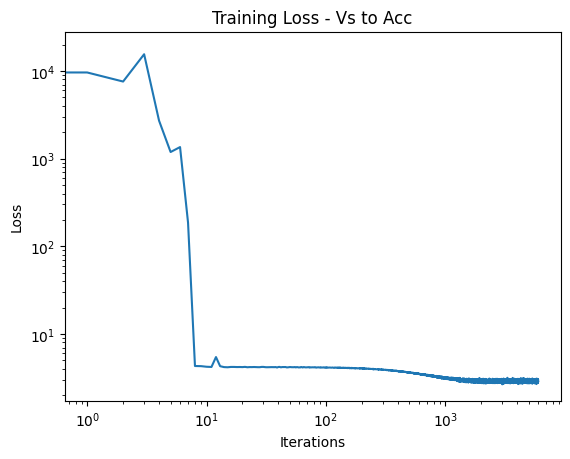

In [64]:
# Plot Loss
plt.loglog(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title("Training Loss - Vs to Acc")
plt.show()

In [65]:
# Check the model on test data
model_vs2acc.eval()
outputs = []
with torch.no_grad():
    for i, (input_data, output_data) in enumerate(Vs_test_loader):
        input_data, output_data = input_data.to(device), output_data.to(device)

        output = model_vs2acc(input_data)

        outputs.append(output.cpu().numpy())
        loss = criterion(output, output_data)
        print(f'Loss: {loss.item()}')

Loss: 2.9361472129821777


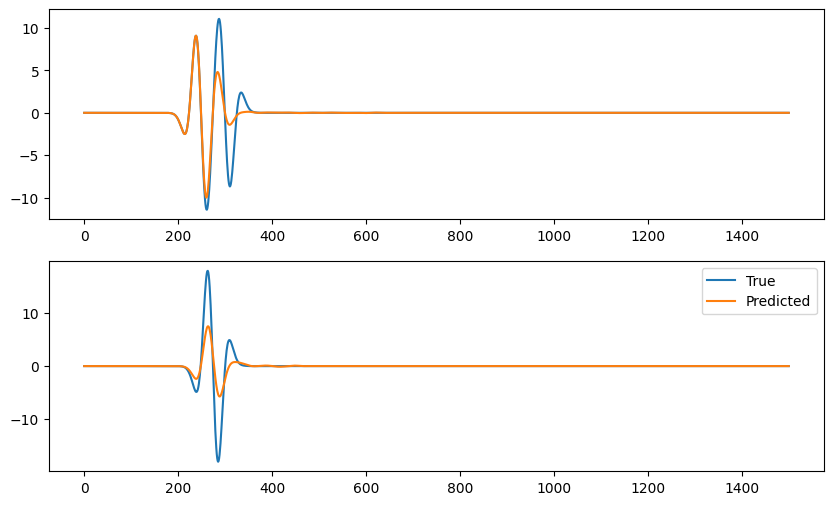

In [66]:
# Plot a sample
ix = np.random.randint(0, output_data.shape[0])
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(output_data.cpu().numpy()[ix][0], label='True')
ax[0].plot(outputs[-1][ix][0], label='Predicted')

ax[1].plot(output_data.cpu().numpy()[ix][1], label='True')
ax[1].plot(outputs[-1][ix][1], label='Predicted')

plt.legend()
plt.show()


tensor([[150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
         150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150., 150.,
         150., 150., 150., 150., 150., 150.]], device='cuda:0')


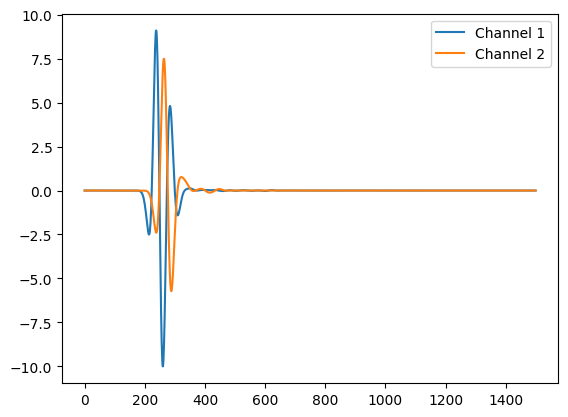

In [67]:
# Vs Try
Vs_try = torch.tensor(150, dtype=torch.float32) * torch.ones(1,30)
Vs_try = Vs_try.to(device)
print(Vs_try)

model_vs2acc.eval()
with torch.no_grad():
    acc_pred = model_vs2acc(Vs_try)

plt.figure()
plt.plot(acc_pred[0][0].cpu().numpy(), label='Channel 1')
plt.plot(acc_pred[0][1].cpu().numpy(), label='Channel 2')
plt.legend()

## Pipeline

In [68]:
class DeepONetPipeline(nn.Module):
    def __init__(self, model_vs2acc, model_acc2ttf):
        """
        Args:
            model_vs2acc: Model that maps Vs material (batch, 30) to accelerations (batch, 2, 1500)
            model_acc2ttf: Model that maps accelerations (batch, 2, 1500) to transfer function (batch, 1000)
        """
        super(DeepONetPipeline, self).__init__()
        self.model_vs2acc = model_vs2acc
        self.model_acc2ttf = model_acc2ttf

    def forward(self, vs):
        # vs: Tensor of shape (batch, 30)
        acc = self.model_vs2acc(vs)      # expected shape: (batch, 2, 1500)
        ttf = self.model_acc2ttf(acc)     # expected shape: (batch, 1000)
        return ttf

In [69]:
model_total = DeepONetPipeline(model_vs2acc, model_acc2tf)
model_total.to(device)

DeepONetPipeline(
  (model_vs2acc): FNO1d_VsToAcc_TwoBranch(
    (branch1): FNO1d_VsToAcc_Channel1(
      (fc0): Linear(in_features=31, out_features=64, bias=True)
      (conv1): SpectralConv1d()
      (conv2): SpectralConv1d()
      (fc1): Linear(in_features=96000, out_features=400, bias=True)
      (fc2): Linear(in_features=400, out_features=1500, bias=True)
    )
    (branch2): FNO1d_VsToAcc_Channel2(
      (fc0): Linear(in_features=31, out_features=64, bias=True)
      (conv1): SpectralConv1d()
      (conv2): SpectralConv1d()
      (fc1): Linear(in_features=96000, out_features=400, bias=True)
      (fc2): Linear(in_features=400, out_features=1500, bias=True)
    )
  )
  (model_acc2ttf): FNO1d(
    (fc0): Linear(in_features=2, out_features=32, bias=True)
    (conv1): SpectralConv1d()
    (conv2): SpectralConv1d()
    (fc1): Linear(in_features=48000, out_features=400, bias=True)
    (fc2): Linear(in_features=400, out_features=1000, bias=True)
  )
)

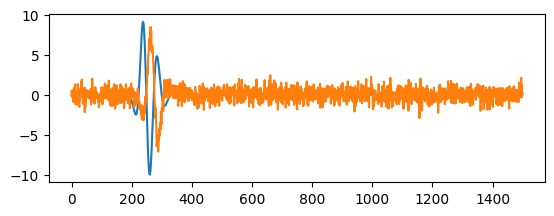

In [70]:
Vs_try = 100 * torch.rand(30).to(device)
model_total.eval()
with torch.no_grad():
    acc_pred = model_total.model_vs2acc(Vs_try.unsqueeze(0))

# Plot a sample
plt.subplot(2, 1, 1)
plt.plot(acc_pred.cpu().numpy()[0][0], label='Channel 1')
plt.plot(acc_pred.cpu().numpy()[0][1], label='Channel 2')


torch.Size([1, 30])


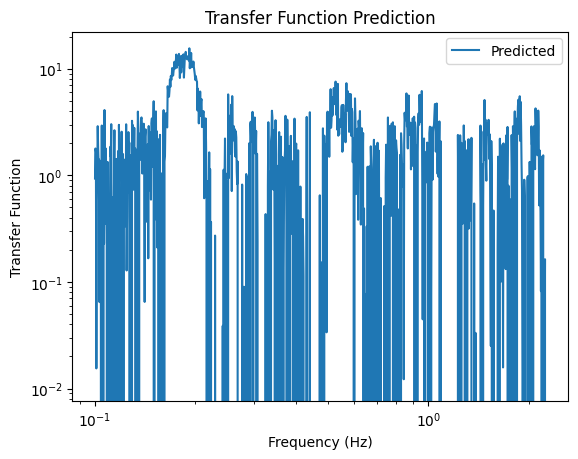

In [71]:
Vs_try = 800 * torch.rand(30).to(device)
Vs_try = Vs_try.unsqueeze(0)
print(Vs_try.shape)

with torch.no_grad():
    ttf_pred = model_total(Vs_try).cpu().numpy()

plt.figure()
plt.loglog(freq_data, ttf_pred[0], label='Predicted')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Transfer Function')
plt.title('Transfer Function Prediction')
plt.legend()
plt.show()